In [1]:
import numpy as np
import scipy.linalg
import scipy.io
import itertools
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit.extensions import UnitaryGate

# custom utility functions
from util import *
from qetu import *
from tfim import *
from fermi_hubbard import *
from wmi_backend_ring import *

In [2]:
backend = WMIBackendRing()
noise_model = NoiseModel.from_backend(backend)
noise_model

<NoiseModel on ['y', 'sx', 'x', 'iswap', 'cp', 'measure', 'xx_plus_yy']>

[(0, 1), (1, 2), (0, 3), (3, 4), (4, 5), (2, 5), (1, 0), (2, 1), (3, 0), (4, 3), (5, 4), (5, 2)]


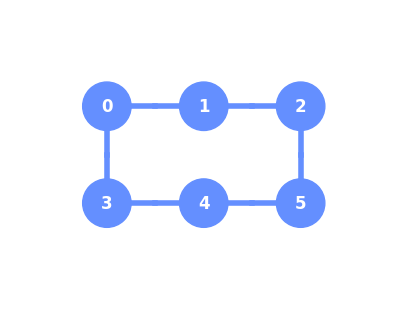

In [3]:
num_qubits = backend.n_qubits
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
coupling_map = backend.coupling_map
print(coupling_map)
plot_coupling_map(num_qubits, qubit_coordinates, coupling_map)

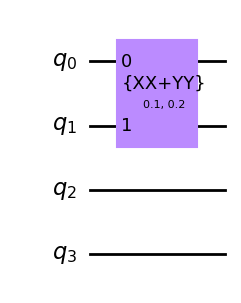

In [5]:
# XX+YY
q = QuantumCircuit(4)
theta = 0.1
beta = 0.2
q.append(XXPlusYYGate(theta, beta), [0, 1])
q.draw("mpl")

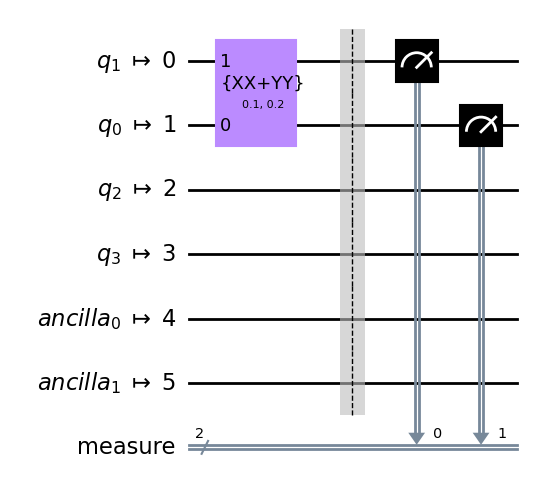

In [6]:
# Transpile to WMI hardware
test_circ = transpile(
    q,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

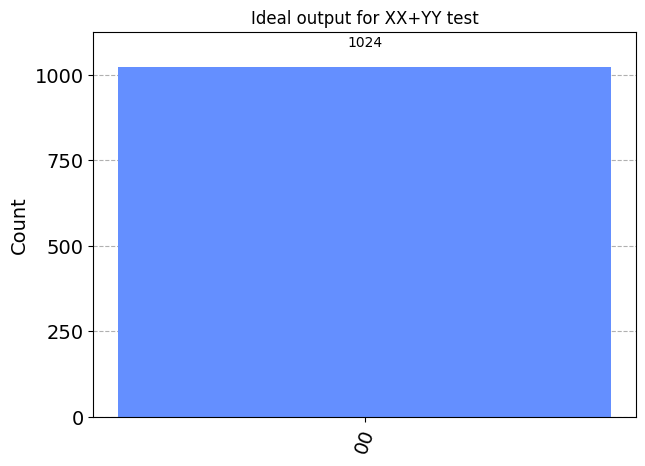

In [7]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for XX+YY test')

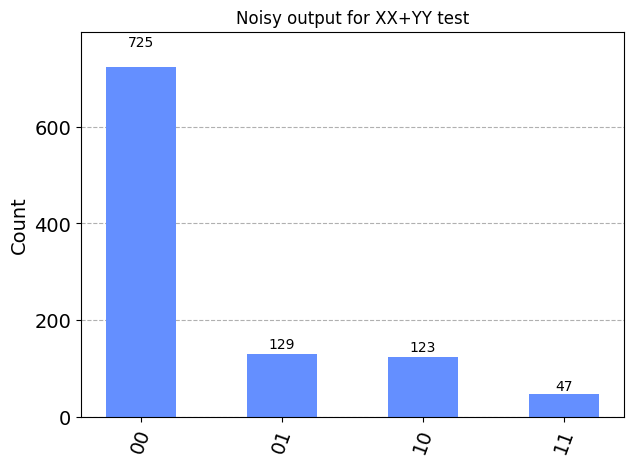

In [8]:
# Create noisy simulator and transpile circuit
wmi_backend = WMIBackendRing()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for XX+YY test')